In [19]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import seaborn as sns
import optuna
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, RocCurveDisplay, auc,classification_report
import warnings
warnings.filterwarnings('ignore')

# **1. Data loading**

In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
df_submission = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')


print(f'Shape of train data: {df_train.shape}')
print(f'Shape of test data: {df_test.shape}')


SEED = 12
n_trials = 2
target = 'Exited'

df_train = df_train.drop(['id', 'Surname'], axis = 1)
df_test = df_test.drop(['id', 'Surname'], axis = 1)


features = df_train.columns.drop(target)
CAT_FEATS = df_train.select_dtypes(include='object').columns
NUM_FEATS = [x for x in df_train.columns if x not in CAT_FEATS and x != target and x in features]

assert target not in features
assert target not in CAT_FEATS
assert target not in NUM_FEATS

Shape of train data: (165034, 14)
Shape of test data: (110023, 13)


# **2. Data Exploration**

## **2.1 Data preview of train and test set**

In [ ]:
df_train.head()

In [ ]:
df_test.head()

## **2.2 Basic stats from of train and test set**

In [ ]:
df_train.describe()

# **3. Feature Analysis**

## **3.1 Numerical feature analysis**

In [ ]:
def plot_distribution_pairs(train, test, feature, hue="set", palette=None):
    df = train.copy()
    df["set"] = "train"    
    df = pd.concat([df, test.copy()]).fillna("test")
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    fig, ax = plt.subplots(1, 2, figsize=(13,4))
    for i, s in enumerate(df[hue].unique()):
        selection = df.loc[df[hue]==s, features]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            g_hist = sns.histplot(selection, ax=ax[0], label=s)
            g_box = sns.boxplot(x=hue, y=feature, data=df, ax=ax[1])
    
    ax[0].set_title(f"Paired train/test distributions of {features}")
    ax[1].set_title(f"Paired train/test boxplots of {features}")
    
    g_hist.legend()
    plt.show()

for feature in NUM_FEATS:
    plot_distribution_pairs(df_train, df_test, features)

## **3.2 Categorical feature analysis**

In [4]:
pd.set_option('display.max_colwidth', None)

def display_categorical_values_table(train_data, test_data, title):
    train_categorical_columns = train_data.select_dtypes(include='object').columns
    test_categorical_columns = test_data.select_dtypes(include='object').columns

    # Create a DataFrame to store unique values for each categorical feature
    data = []
    for column in train_categorical_columns:
        train_unique_values = train_data[column].nunique()
        test_unique_values = test_data[column].nunique() if column in test_categorical_columns else None
        
        # Check if train and test have different levels
        different_levels = False
        if test_unique_values is not None:
            train_levels = set(train_data[column].unique())
            test_levels = set(test_data[column].unique())
            different_levels = train_levels.symmetric_difference(test_levels)
        
        data.append([column, train_unique_values, test_unique_values, different_levels])

    # Display the tabular representation
    print(f"\n{title} - Unique values for categorical features:")
    df = pd.DataFrame(data, columns=['Feature', 'Train_Unique_Values', 'Test_Unique_Values', 'Different_Levels'])
    display(df)


# Display unique values for categorical features for both train and test data
display_categorical_values_table(df_train, df_test, title='Train and Test Data')



Train and Test Data - Unique values for categorical features:


,Feature,Train_Unique_Values,Test_Unique_Values,Different_Levels
0,Geography,3,3,{}
1,Gender,2,2,{}


# **4. Missing value analysis**

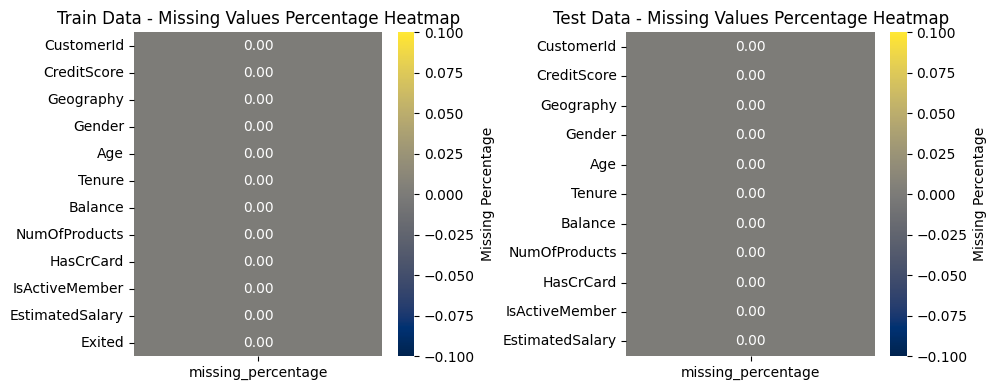

In [5]:
def plot_missing_values_heatmap(data, title, subplot_position):
    # Calculate the percentage of missing values for each column
    missing_percentage = data.isnull().mean() * 100

    # Create a DataFrame with missing percentage information
    missing_info = pd.DataFrame({'column': data.columns, 'missing_percentage': missing_percentage})

    # Create a heatmap grid highlighting missing values percentage
    plt.subplot(subplot_position)
    sns.heatmap(missing_info[['missing_percentage']], cmap='cividis', annot=True, fmt='.2f', cbar_kws={'label': 'Missing Percentage'})
    plt.title(f'{title} - Missing Values Percentage Heatmap')

# Create a single figure with one row and two columns
plt.figure(figsize=(10, 4))

# Plot missing values heatmap for the training data
plot_missing_values_heatmap(df_train, title='Train Data', subplot_position=121)

# Plot missing values heatmap for the test data
plot_missing_values_heatmap(df_test, title='Test Data', subplot_position=122)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# **5. Target Feature Analysis**

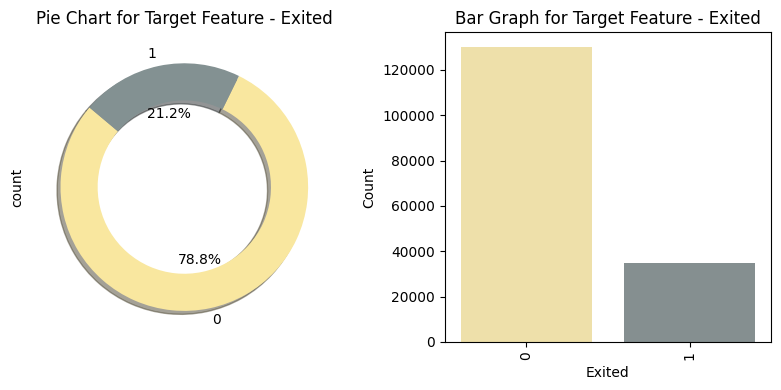

In [6]:
# Analysis of TARGET feature

# Define a custom color palette for categorical features
target_palette = ['#F9E79F', '#839192']

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Pie Chart
plt.subplot(1, 2, 1)
df_train[target].value_counts().plot.pie(autopct='%1.1f%%', colors=target_palette, wedgeprops=dict(width=0.3), startangle=140, ax=axes[0],shadow=True)
plt.title(f"Pie Chart for Target Feature - {target}")

# Bar Graph
plt.subplot(1, 2, 2)
sns.countplot(data=pd.concat([df_train]), x=target, palette=target_palette)
plt.ylabel("Count")
plt.title(f"Bar Graph for Target Feature - {target}")
plt.xticks(rotation=90)
# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# **6. Correlation Matrix**

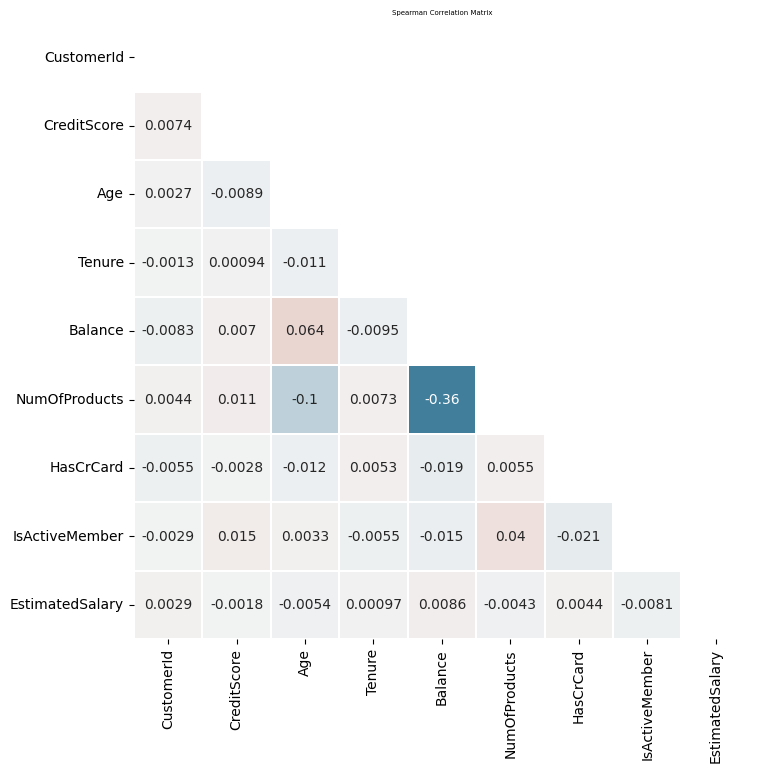

In [7]:
from matplotlib.colors import SymLogNorm

correlation_matrix = df_train[NUM_FEATS].corr()
f, ax = plt.subplots(figsize=(10, 8))
_ = sns.heatmap(
    correlation_matrix, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), 
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0,
    square=True, 
    linewidths=.1, 
    cbar=False,
    ax=ax,
    annot=True,
)
_ = ax.set_title("Spearman Correlation Matrix", fontsize=5)

In [ ]:
# # Find different levels in each column
# for column in df_train.columns:
#     unique_levels = df_train[column].unique()
#     print(f"Levels in {column}: {unique_levels}")

In [8]:
# Encode all the categorical features
df_train_cat_encode = df_train[CAT_FEATS]
df_test_cat_encode= df_test[CAT_FEATS]

# Dummify the train and test data
df_train_cat_encoded = pd.get_dummies(df_train_cat_encode, columns = CAT_FEATS, drop_first=True)
df_test_cat_encoded = pd.get_dummies(df_test_cat_encode, columns = CAT_FEATS, drop_first=True)

In [9]:
df_train_cat_encoded.head()

,Geography_Germany,Geography_Spain,Gender_Male
0,False,False,True
1,False,False,True
2,False,False,True
3,False,False,True
4,False,True,True


In [10]:
df_test_cat_encoded.head()

,Geography_Germany,Geography_Spain,Gender_Male
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,True
4,True,False,True


In [11]:
# Scale all the numerical features
df_train_num_scale = df_train[NUM_FEATS]
df_test_num_scale = df_test[NUM_FEATS]

from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
minmax_scaler = MinMaxScaler()

# Fit the scaler on the training data
minmax_scaler.fit(df_train_num_scale)

# Scale the training data
df_train_num_scaled = minmax_scaler.transform(df_train_num_scale)
df_train_num_scaled = pd.DataFrame(df_train_num_scaled, columns=df_train_num_scale.columns)

# Scale the test data using the parameters from the training data
df_test_num_scaled = minmax_scaler.transform(df_test_num_scale)
df_test_num_scaled = pd.DataFrame(df_test_num_scaled, columns=df_test_num_scale.columns)


In [12]:
# Concatenate datasets
df_train_combined = pd.concat([df_train_cat_encoded.reset_index(drop=True), df_train_num_scaled.reset_index(drop=True)], axis=1)

# Concatenate test datasets
df_test_combined = pd.concat([df_test_cat_encoded.reset_index(drop=True), df_test_num_scaled.reset_index(drop=True)], axis=1)

In [13]:
df_train_combined['Exited'] = df_train['Exited']

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = df_train_combined.drop(columns=[target])
y = df_train_combined[target]

In [31]:
def plot_roc_curve(model, X_test, y_test):
    # Compute predicted probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.text(0.6, 0.2, 'AUC = %0.2f' % roc_auc, fontsize=12, ha='center')
    plt.show()

In [ ]:
# import imblearn
# from imblearn.over_sampling import SMOTE
# smote = SMOTE()
# X, y = smote.fit_resample(X, y)
# print("Before Smoote" , y.value_counts())
# print()
# print("After Smoote" , y_smote.value_counts())

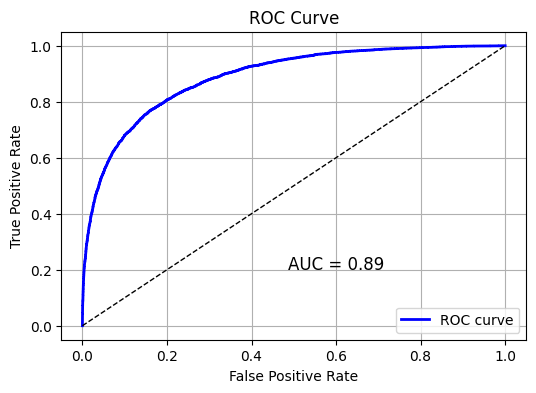

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = XGBClassifier()
model.fit(X_train, y_train)
# Plot ROC curve
plot_roc_curve(model, X_test, y_test)

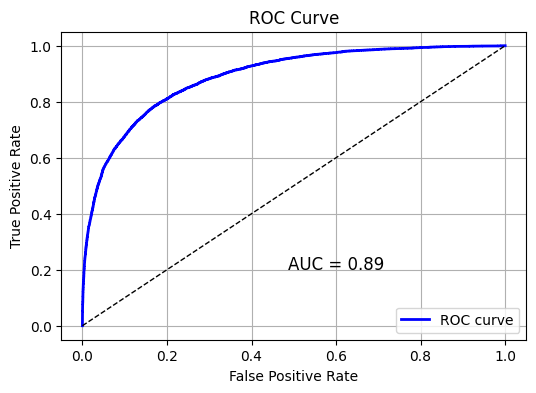

In [45]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = CatBoostClassifier(verbose = 0)
model.fit(X_train, y_train)
# Plot ROC curve
plot_roc_curve(model, X_test, y_test)

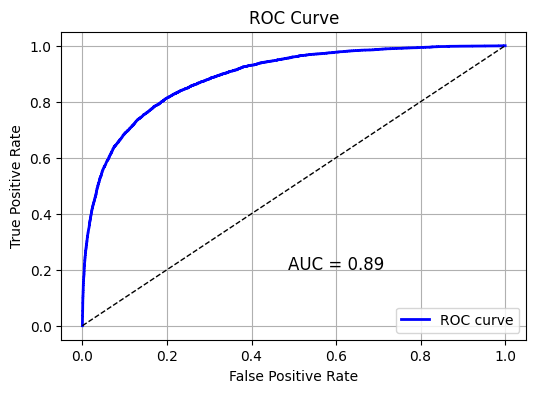

In [46]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LGBMClassifier(verbose = -1)
model.fit(X_train, y_train)
# Plot ROC curve
plot_roc_curve(model, X_test, y_test)

## Hyperparameter tuning

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # Define the hyperparameters to optimize
    params = {
            'max_depth': trial.suggest_int('max_depth', 5, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
            'subsample': trial.suggest_float('subsample', 0.01, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
            'random_state': trial.suggest_categorical('random_state', [42]),
            'tree_method': 'hist',  
            'device': 'cuda',
            'eval_metric': 'auc',  # Evaluation metric
            'verbosity': 0,  # Set verbosity to 0 for less output
        }

    # Create and train the model with the suggested hyperparameters
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    
    return auc

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

# Print the best hyperparameters and the corresponding objective value
print("Best hyperparameters:", study.best_params)
print("Best objective value (Mean Squared Error):", study.best_value)
xgb_params = study.best_params

[I 2024-02-16 05:51:57,590] A new study created in memory with name: no-name-2c6707d8-f314-41a3-9ae5-ea64e7180786
[I 2024-02-16 05:52:05,269] Trial 0 finished with value: 0.8385562696428743 and parameters: {'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.425922756337654, 'n_estimators': 500, 'subsample': 0.5248135220809664, 'colsample_bytree': 0.45541065608134396, 'random_state': 42}. Best is trial 0 with value: 0.8385562696428743.
[I 2024-02-16 05:52:13,936] Trial 1 finished with value: 0.8891138284179305 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'learning_rate': 0.018827472201810115, 'n_estimators': 553, 'subsample': 0.5613451882883578, 'colsample_bytree': 0.93974963600742, 'random_state': 42}. Best is trial 1 with value: 0.8891138284179305.


Best hyperparameters: {'max_depth': 10, 'min_child_weight': 7, 'learning_rate': 0.018827472201810115, 'n_estimators': 553, 'subsample': 0.5613451882883578, 'colsample_bytree': 0.93974963600742, 'random_state': 42}
Best objective value (Mean Squared Error): 0.8891138284179305


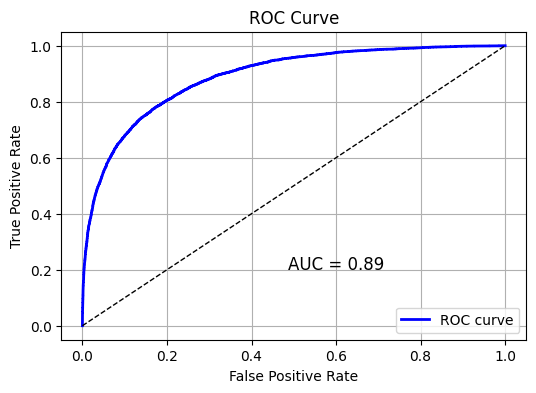

In [39]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = XGBClassifier(**xgb_params)
model.fit(X_train, y_train)
# Plot ROC curve
plot_roc_curve(model, X_test, y_test)

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'iterations': trial.suggest_int('iterations', 200, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 20),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.2, log=True),
        'random_state': 42,
        'verbose': 0,
        'eval_metric': 'AUC',
    }

    # Create and train the model with the suggested hyperparameters
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    
    return auc

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

# Print the best hyperparameters and the corresponding objective value
print("Best hyperparameters:", study.best_params)
cat_params = study.best_params


[I 2024-02-16 05:53:36,596] A new study created in memory with name: no-name-301df2df-5297-473d-88e4-e78f5040aeb9
[I 2024-02-16 05:53:47,982] Trial 0 finished with value: 0.8840167174361118 and parameters: {'iterations': 564, 'depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.00029747662750494104}. Best is trial 0 with value: 0.8840167174361118.
[I 2024-02-16 05:54:00,715] Trial 1 finished with value: 0.8877989582964247 and parameters: {'iterations': 630, 'depth': 7, 'min_data_in_leaf': 14, 'learning_rate': 0.0026947099016675457}. Best is trial 1 with value: 0.8877989582964247.


Best hyperparameters: {'iterations': 630, 'depth': 7, 'min_data_in_leaf': 14, 'learning_rate': 0.0026947099016675457}


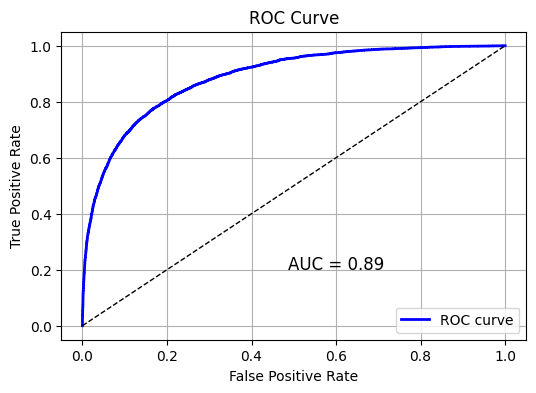

In [42]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = CatBoostClassifier(**cat_params, verbose = 0)
model.fit(X_train, y_train)
# Plot ROC curve
plot_roc_curve(model, X_test, y_test)

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
    }

    # Create and train the model with the suggested hyperparameters
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    
    return auc

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

# Print the best hyperparameters and the corresponding objective value
print("Best hyperparameters:", study.best_params)
lgb_params = study.best_params

[I 2024-02-16 05:54:18,395] A new study created in memory with name: no-name-3177a799-670d-4faa-a62a-859f248d5a0c
[I 2024-02-16 05:54:23,392] Trial 0 finished with value: 0.8897022164265176 and parameters: {'max_depth': 6, 'min_child_samples': 20, 'learning_rate': 0.17544229643698633, 'n_estimators': 398, 'subsample': 0.42382684032586415, 'colsample_bytree': 0.6930861459116431, 'reg_alpha': 0.8433826655503633, 'reg_lambda': 0.6277023884544658}. Best is trial 0 with value: 0.8897022164265176.
[I 2024-02-16 05:54:35,564] Trial 1 finished with value: 0.8699077236777896 and parameters: {'max_depth': 5, 'min_child_samples': 2, 'learning_rate': 0.4538389828867779, 'n_estimators': 949, 'subsample': 0.8090979785106716, 'colsample_bytree': 0.5723254050618968, 'reg_alpha': 0.8509371424353827, 'reg_lambda': 0.8131000096567771}. Best is trial 0 with value: 0.8897022164265176.


Best hyperparameters: {'max_depth': 6, 'min_child_samples': 20, 'learning_rate': 0.17544229643698633, 'n_estimators': 398, 'subsample': 0.42382684032586415, 'colsample_bytree': 0.6930861459116431, 'reg_alpha': 0.8433826655503633, 'reg_lambda': 0.6277023884544658}


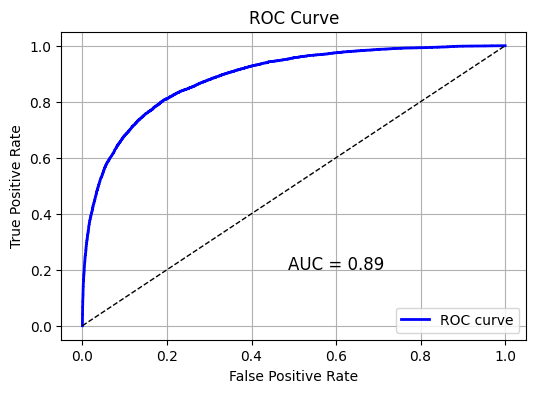

In [44]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LGBMClassifier(**lgb_params, verbose = -1)
model.fit(X_train, y_train)
# Plot ROC curve
plot_roc_curve(model, X_test, y_test)

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

val_scores = []
def evaluate_model(model, X, y):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=12)
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:, 1]

        val_score = roc_auc_score(y_val, y_pred)

        print(f"###### FOLD {fold + 1} ######")
        print(f"AUC Score: {val_score:.4f}")

        val_scores.append(val_score)

    mean_score = np.mean(val_scores)
    score_std = np.std(val_scores)
    return val_scores

# Ensemble using voting classifier

In [27]:
from sklearn.ensemble import VotingClassifier

xgb_clf = XGBClassifier(**xgb_params)
lgb_clf = LGBMClassifier(**lgb_params)
cat_clf = CatBoostClassifier(**cat_params, verbose=False)

eclf = VotingClassifier(
    estimators=[("xgb", xgb_clf), ("lgb", lgb_clf), ("cat", cat_clf)],
    voting="soft"
)

val_scores.append(evaluate_model(eclf, X, y))

# y_test = df_test_combined.copy()

predictions = eclf.predict_proba(df_test_combined)[:, 1]

sub = pd.DataFrame({"id": df_submission['id'], 'Exited': predictions})
sub

###### FOLD 1 ######
AUC Score: 0.8828
###### FOLD 2 ######
AUC Score: 0.8876
###### FOLD 3 ######
AUC Score: 0.8926
###### FOLD 4 ######
AUC Score: 0.8894
###### FOLD 5 ######
AUC Score: 0.8938
###### FOLD 6 ######
AUC Score: 0.8865
###### FOLD 7 ######
AUC Score: 0.8891
###### FOLD 8 ######
AUC Score: 0.8913
###### FOLD 9 ######
AUC Score: 0.8927
###### FOLD 10 ######
AUC Score: 0.8938


,id,Exited
0,165034,0.026598
1,165035,0.825920
2,165036,0.036071
3,165037,0.244587
4,165038,0.372460
...,...,...
110018,275052,0.048926
110019,275053,0.133156
110020,275054,0.029951
110021,275055,0.173877


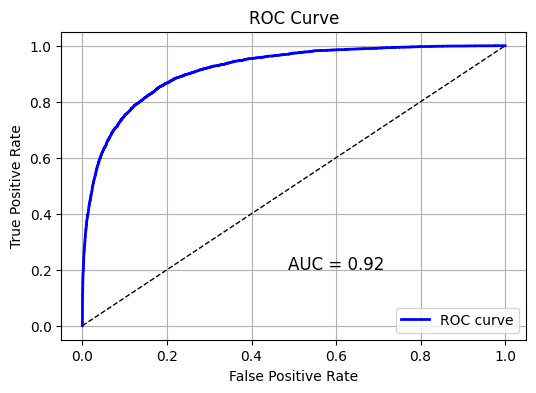

In [35]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Plot ROC curve
plot_roc_curve(eclf, X_test, y_test)

# Ensemble using average method

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of classifiers and their corresponding predictions
classifiers = [(xgb_clf, 'xgb'), (lgb_clf, 'lgb'), (cat_clf, 'cat')]

# Dictionary to store predictions
predictions = {}

# Loop through each classifier
for clf, name in classifiers:
    # Fit the classifier on the training data
    clf.fit(X_train, y_train)
    # Make predictions on the test data and store them in the predictions dictionary
    predictions[name] = clf.predict_proba(df_test_combined)[:, 1]

# Access the predictions for each classifier using its name
xgb_preds = predictions['xgb']
lgb_preds = predictions['lgb']
cat_preds = predictions['cat']

# Calculate average predictions
ensemble_pred = (xgb_preds + lgb_preds + cat_preds) / 3
ensemble_pred

sub = pd.DataFrame({"id": df_submission['id'], 'Exited': ensemble_pred})
sub


# Ensemble using weighed averaging

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgb_clf.fit(X_train, y_train, verbose=0)
lgb_clf.fit(X_train, y_train, verbose=0)
cat_clf.fit(X_train, y_train, verbose=0)

def objective(trial):
    xgb_weight = trial.suggest_uniform('xgb_weight', 0, 1)
    lgb_weight = trial.suggest_uniform('lgb_weight', 0, 1)
    cat_weight = trial.suggest_uniform('cat_weight', 0, 1)

    # Normalize weights to sum up to 1
    total_weight = xgb_weight + lgb_weight + cat_weight
    xgb_weight /= total_weight
    lgb_weight /= total_weight
    cat_weight /= total_weight

    # Ensemble predictions
    ensemble_pred_proba = (
        xgb_weight * xgb_clf.predict_proba(X_test)[:, 1] +
        lgb_weight * lgb_clf.predict_proba(X_test)[:, 1] +
        cat_weight * cat_clf.predict_proba(X_test)[:, 1]
    )

    # Assuming y_test is available
    auc_score = roc_auc_score(y_test, ensemble_pred_proba)

    return auc_score

# Optimize using Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Get the best weights
best_weights = study.best_params
best_weights

In [ ]:
# Define a list of classifiers, their corresponding predictions, and weights
classifiers = [(xgb_preds, best_weights['xgb_weight']), 
               (lgb_preds, best_weights['lgb_weight']), 
               (cat_preds, best_weights['cat_weight'])]

# Calculate the weighted average of predicted probabilities
ensemble_pred_proba = sum(pred * weight for pred, weight in classifiers)

# Create a DataFrame for submission
ensemble_submission_df = pd.DataFrame({"id": df_submission['id'], 'Exited': ensemble_pred_proba})
ensemble_submission_df